With a calibrated (phone) camera and a video tour of my room, I should be able to estimate the camera's motion by doing feature detection between frames.

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cap = cv.VideoCapture('VID_20251213_144323.mp4')

In [3]:
calib = np.load('phonecam_calib.npz')
K = calib['mtx']
dist = calib['dist']

In [4]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    undist = cv.undistort(frame, K, dist)
    cv.imshow('undistorted', undist)

    if cv.waitKey(1) == 27:
        break
cv.destroyAllWindows()

In [5]:
cap = cv.VideoCapture('VID_20251210_143222.mp4')
ret, frame = cap.read()

# Next: recover pose between each pair of frames

In [27]:
def spatial_nms(kp, matches, grid_size=20):
    """Perform simple non-maximal suppression on the matches.
    This prevents us from getting multiple matches representing
    very close pixel areas.
    """
    used_cells = set()
    filtered_matches = []

    for m in sorted(matches, key=lambda x: x.distance):
        x, y = map(int, kp[m.queryIdx].pt)
        cell = (x // grid_size, y // grid_size)
        if cell not in used_cells:
            filtered_matches.append(m)
            used_cells.add(cell)
    return filtered_matches

def detect_and_match(frame1, frame2):
    # Detect SIFT features
    sift = cv.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(frame1, None)
    kp2, desc2 = sift.detectAndCompute(frame2, None)

    # Do FLANN matching
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)

    pts1, pts2 = list(), list()
    # Filter points via Lowe's ratio test to remove unreliable matches
    thresh = 0.7
    good_matches = [m for (m,n) in matches if m.distance < thresh * n.distance]

    # Filter via spatial NMS on good matches to remove redundant matches
    filtered_matches = spatial_nms(kp1, good_matches, grid_size=20)

    # Extract points from the filtered matches
    pts1 = np.float32([kp1[m.queryIdx].pt for m in filtered_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in filtered_matches])

    # print(f"Found {len(filtered_matches)} matches.")
    return pts1, pts2


def estimate_pose(frame1, frame2, cameraMatrix, distCoeffs):
    """Given two subsequent frames of a video, estimate the pose of the camera between the frames.
    This is done by feature detection and matching.
    """

    pts1, pts2 = detect_and_match(frame1, frame2)

    F, mask = cv.findFundamentalMat(
        points1=pts1,
        points2=pts2,
        method=cv.FM_RANSAC,
        ransacReprojThreshold=1.0,
        confidence=0.99,
    )

    E = cameraMatrix.T @ F @ cameraMatrix

    # Recover the pose
    ret, _, R, t, mask = cv.recoverPose(
        points1=pts1.astype(np.float32),
        points2=pts2.astype(np.float32),
        cameraMatrix1=cameraMatrix,
        cameraMatrix2=cameraMatrix,
        distCoeffs1=distCoeffs,
        distCoeffs2=distCoeffs,
        E=E,
    )

    return (R,t)


# --- Main loop ---
cap = cv.VideoCapture('VID_20251213_144323.mp4')
ret, frame1 = cap.read()

poses = []

frames_processed = 0
# while frames_processed < 480:
while True:
    ret, frame2 = cap.read()
    if not ret:
        break   # end of video

    try:
        pose = estimate_pose(frame1, frame2, K, dist)

        poses.append(pose)
    except:
        pass

    # Prep for next iteration
    frame1 = frame2
    ret, frame2 = cap.read()
    if not ret:
        break   # end of video

    frames_processed += 1

cap.release()

In [45]:
# Compute the global trajectory of the pose
global_R = [np.eye(3)]
global_t = [np.zeros((3,1))]

for R_i, t_i in poses:
    R_prev = global_R[-1]
    t_prev = global_t[-1]

    R_new = R_prev @ R_i
    t_i_sc = t_i / np.linalg.norm(t_i)
    t_new = t_prev + R_prev @ t_i_sc.reshape(3,1)

    global_R.append(R_new)
    global_t.append(t_new)

In [46]:
global_t = np.stack(global_t, axis=1)[:,:,0].T

<function matplotlib.pyplot.show(block=None)>

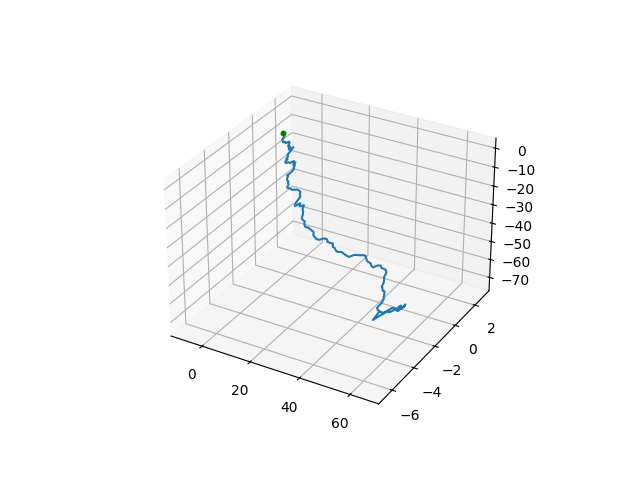

In [47]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(global_t[:, 0], global_t[:, 1], global_t[:, 2], '-')
# mark start position
ax.scatter(global_t[0,0], global_t[0,1], global_t[0,2], c='green', s=10)
plt.show

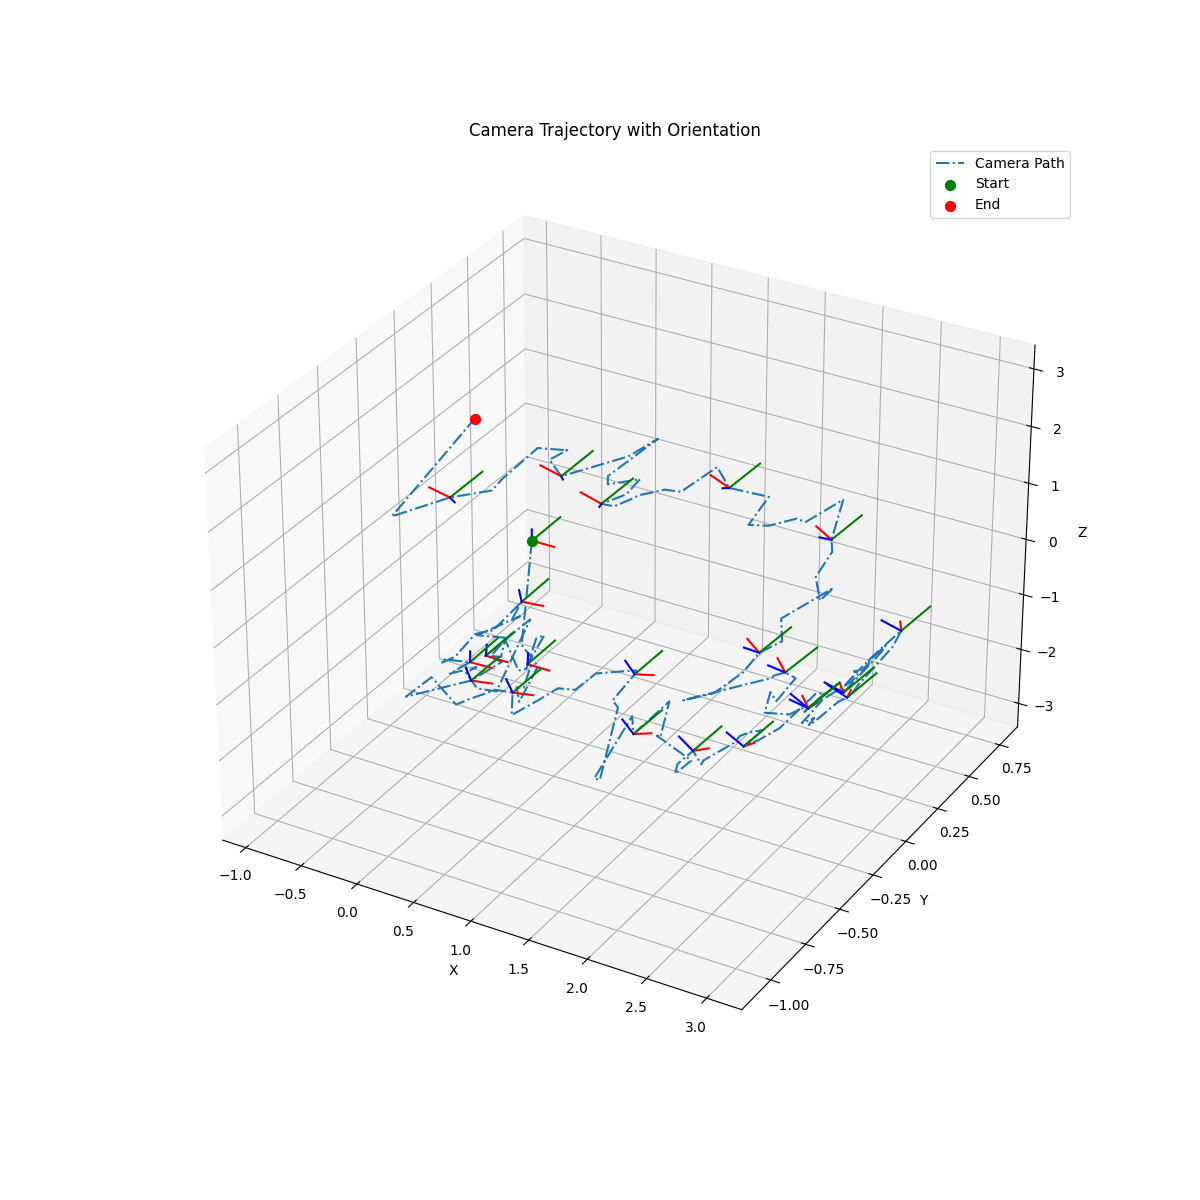

In [42]:
%matplotlib widget
def draw_camera_frame(ax, R, t, scale=0.1):
    """
    Draw a camera coordinate frame at position t with orientation R.
    ax    : matplotlib 3d axis
    R     : 3x3 rotation matrix (camera orientation)
    t     : 3x1 translation vector (camera position)
    scale : length of the coordinate frame axes
    """
    origin = t.flatten()
    x_axis = origin + scale * R[:, 0]  # Red = X
    y_axis = origin + scale * R[:, 1]  # Green = Y
    z_axis = origin + scale * R[:, 2]  # Blue = Z

    ax.plot([origin[0], x_axis[0]], [origin[1], x_axis[1]], [origin[2], x_axis[2]], c='r')
    ax.plot([origin[0], y_axis[0]], [origin[1], y_axis[1]], [origin[2], y_axis[2]], c='g')
    ax.plot([origin[0], z_axis[0]], [origin[1], z_axis[1]], [origin[2], z_axis[2]], c='b')

# Assuming global_R and global_t are lists of rotation matrices and translation vectors

positions = np.array([t.flatten() for t in global_t])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# Plot camera trajectory
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], '-.', label='Camera Path')
ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], color='green', s=50, label='Start')
ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], color='red', s=50, label='End')


# Draw coordinate frames every N frames to reduce clutter
for i in range(0, len(global_R), max(1, len(global_R)//20)):
    # draw_camera_frame(ax, global_R[i], global_t[i], scale=0.05)
    draw_camera_frame(ax, global_R[i], global_t[i], scale=0.2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Camera Trajectory with Orientation')
ax.legend()
ax.grid(True)

plt.show()